In [1]:
import os
import gc
import re
import random
import time

import numpy as np



from scipy import sparse
from tqdm import tqdm
from typing import List, Tuple


from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score
# from utils_ml import * 
from utils_word import *
from utils_graph import * 

In [2]:
concept_filtered_arr = np.memmap("saved_files/embedding_concept_arr.dat",shape=(10225,), dtype="<U55")
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
saved_year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")
NUM_OF_VERTICES=len(concept_filtered_arr)

print("Concepts which were tracked",concept_filtered_arr.shape)
print("Abstracts",ngram_abstracts.shape)
print("Year associated to abstract",saved_year_arr.shape)

Concepts which were tracked (10225,)
Abstracts (66839,)
Year associated to abstract (66839,)


# knowledge Baseline

In [3]:
# def replace_strings_with_indices(data, concept_to_index):
#     # Create a new dictionary to store the converted data
#     indexed_data = {}
    
#     # Iterate through the outer dictionary
#     for concept1, nested_dict in data.items():
#         # Replace the concept1 string with its index
#         # print(concept_to_index[concept1])
#         index1 = concept_to_index[concept1][0]
#         indexed_data[index1] = {}
        
#         # Iterate through the inner dictionary
#         for concept2, years in nested_dict.items():
#             # Replace the concept2 string with its index
            
#             index2 = concept_to_index[concept2][0]
#             indexed_data[index1][index2] = years
    
#     return indexed_data


# concept_to_indices = {concept: np.where(concept_filtered_arr == concept)[0] for concept in np.unique(concept_filtered_arr)}
# index_co_occurrences = replace_strings_with_indices(word_co_occurrences, concept_to_indices)

In [4]:
load = True 
if not load:
    word_co_occurrences = get_word_co_occurrences(concept_filtered_arr, ngram_abstracts, saved_year_arr)
    graph = create_graph_from_dict(word_co_occurrences)
    save_graph_edges(graph, 'saved_files/graph_edges.pkl')

    # Print the edge list to verify
    with open('saved_files/graph_edges.pkl', 'rb') as f:
        edge_list = pickle.load(f)
        print(edge_list[0])
        print(edge_list[-1])
        print(len(edge_list))


# Neural Network Train model

In [5]:

import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to perform evaluation in batches
def evaluate_model_in_batches(model, eval_examples, batch_size=64):
    # Select the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Convert eval_examples to a PyTorch tensor if not already one, and move to the selected device
    if not isinstance(eval_examples, torch.Tensor):
        eval_tensor = torch.tensor(eval_examples, dtype=torch.float).to(device)
    else:
        eval_tensor = eval_examples.clone().detach().float().to(device)

    # Create a DataLoader for batch processing
    eval_dataset = TensorDataset(eval_tensor)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    all_predictions_eval = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for batch in eval_loader:
            batch = batch[0]  # DataLoader returns batches as tuples
            # Forward pass through the model
            outputs = model(batch)
            # Move the outputs to CPU and convert to numpy array
            predictions = outputs.detach().cpu().numpy()
            # Flatten and store the predictions
            all_predictions_eval.extend(predictions.flatten())

    return all_predictions_eval
# Usage example
batch_size = 256  # Adjust the batch size as needed

def link_prediction_semnet(full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start, year_delta,vertex_degree_cutoff,min_edges,hyper_parameters,data_source):
    """
    Gets an evolving semantic network and a list of unconnected vertices,
    and returns an index list of which vertex pairs are most likely to be
    connected at a later time t2 (from likely to unlikely)
    
    :param full_dynamic_graph_sparse: Full graph, numpy array dim(n,3)
            [vertex v1, vertex v2, time stamp t1] representing edges, up
            to t<=t1. The edge is formed between vertex v1 and v2 at time t
            (measured in days after 1.1.1990)
    :param unconnected_vertex_pairs, numpy array of vertex
            pairs [v1,v2] with no edge at t1 and deg(v1/2)>10. Question is
            whether these vertex pairs will have an edge at t2.
    :param year_start - Integer, year for t1. Edges with
            t1=(date(year_start,12,31)-date(1990,1,1)).days are included
            in full_dynamic_graph_sparse
    :param years_delta, Integer, number if years to predict,
            t2=(date(year_start+years_delta,12,31)-date(1990,1,1)).days
    :param vertex_degree_cutoff, Integer, number of minimal vertex degree for
            prediction 
    :param min_edges, Integer, Predict edges which grew from zero to min_edges 
        
    Output - sorted_predictions_eval, numpy array with
            len(..)=len(unconnected_vertex_pairs).
            Sorted of which pairs in unconnected_vertex_pairs
            are most likely to be connected at t2. Used for computing the
            AUC metric.

    
    This is a simple baseline model, with the following workflow:
    1) Learns to predict using training data from 2011 -> 2014.
          1.1) For that, it uses 
                     train_dynamic_graph_sparse,
                     train_edges_for_checking,
                     train_edges_solution=
                     create_training_data(
                                          full_graph,
                                          year_start=2014,
                                          years_delta=3,
                                          edges_used,
                                          vertex_degree_cutoff
                                         )
               train_dynamic_graph_sparse - Semantic network until 2014
               (numpy array with triples for each edge [v1,v2,t])
               train_edges_for_checking - list of unconnected vertices in
               2011 and computes whether they are connected by 2014.
                   
               edges_used, unconnected edges that are used in training.
               
               train_edges_solution is a numpy array stating whether an
               element in edges_used has beendata_source connected in t2
               
          1.2) It computes a list of 15 properties of each edge in the
               train_edges_for_checking. The properties contain the
               local degrees of the vertices, numbers of shared neighbors
               and paths of length 3, in the year 2011, 2010 and 2009.
          1.3) Those 15 properties per vertex pair are input into a neural
               network, which predicts whether the vertex pairs will be
               connected or not (using train_edges_solution)
          1.4) Computes the AUC for training and test data using
               calculate_ROC.
    
    2) Makes predictions for 2014 -> 2017 data.
          2.1) Computes the 15 properties for the 2014 data.
          2.2) Uses the trained network to predict whether edges are
               created by 2017.
    
    3) Creates a sorted index list, from highest predicted vertex pair to
        least predicted one (sorted_predictions)
    
    4) Returns sorted_predictions
    """

    edges_used, percent_positive_examples, batch_size, lr_enc, rnd_seed=hyper_parameters

    random.seed(rnd_seed)
    torch.manual_seed(rnd_seed)
    np.random.seed(rnd_seed)
    
    print('1) Learns to predict using training data from '+str(year_start-year_delta)+' -> '+str(year_start))
    
    print('1.1) Create training data for '+str(year_start-year_delta))

    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('1.1) Create training data for '+str(year_start-year_delta)+'\n') 
    
    #create_training_data_biased
    #train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, min_edges=min_edges, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)
    train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data_biased(full_dynamic_graph_sparse, year_start-year_delta, year_delta, NUM_OF_VERTICES=NUM_OF_VERTICES,min_edges=min_edges, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff, data_source=data_source)

    day_origin = date(1990,1,1)
    years=[year_start-year_delta,year_start-year_delta-1,year_start-year_delta-2]
    print('    years: ', years)
    train_sparse=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
    
        train_sparse.append(adj_mat_sparse_curr)
    
    
    print('    Shuffle training data...')
    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('\n    Shuffle training data...\n')     
    train_valid_test_size=[0.9, 0.1, 0.0]
    x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input

    random.shuffle(x)
    train_edges_for_checking = train_edges_for_checking[x]
    train_edges_solution = train_edges_solution[x]

    print('    Split dataset...')
    idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])

    data_edges_train=train_edges_for_checking[0:idx_traintest]
    solution_train=train_edges_solution[0:idx_traintest]  

    data_edges_test=train_edges_for_checking[idx_traintest:]
    solution_test=train_edges_solution[idx_traintest:]

    gc.collect()

    print('1.2) Compute 15 network properties for training data y=',year_start-year_delta)

    print('    Prepare data for equally distributed training...')
    print('    This is an important design choice for training the NN.')
    print('    Note that the evaluation set (also for the competition) is NOT equally distributed!')
    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('\n1.2) Compute 15 network properties for training data y='+str(year_start-year_delta))   

    # Rather than using all connected and unconnected vertex pairs for training
    # (i.e. needing to compute their properties), we reject about 99% of all unconnected
    # examples, to have more examples of connected cases in the training. This significantly
    # speeds up the computation, at the price of precision.
    data_edges_train_smaller=[]
    solution_train_smaller=[]
    for ii in range(len(data_edges_train)):
        if (solution_train[ii]==0 and random.random()<percent_positive_examples) or solution_train[ii]==1:
            data_edges_train_smaller.append(data_edges_train[ii])
            solution_train_smaller.append(solution_train[ii])
    
    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('\nComputing properties for Training data')   
    print('Computing properties for Training data')
    data_train=compute_all_properties_of_list(train_sparse,data_edges_train_smaller,data_source)
    gc.collect()

    data_train0=[]
    data_train1=[]
    for ii in range(len(data_edges_train_smaller)):
        if solution_train_smaller[ii]==1:
            data_train1.append(data_train[ii])
        else:
            data_train0.append(data_train[ii])

    gc.collect()
    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('\nComputing properties for Test data')   
    print('Computing properties for Test data')
    data_test=compute_all_properties_of_list(train_sparse,data_edges_test,data_source)
    data_test0=[]
    data_test1=[]
    for ii in range(len(data_edges_test)):
        if solution_test[ii]==1:
            data_test1.append(data_test[ii])
        else:
            data_test0.append(data_test[ii])

    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('\n1.3) Train Neural Network')   
    print('1.3) Train Neural Network')      
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_semnet = MLP().to(device)
    gc.collect()
    model_semnet.train()
    train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size, data_source, year_start-year_delta, year_delta)    
    
    with open(data_source+"_logs.txt", "a") as myfile:
        myfile.write('\n1.4) Computes the AUC for training and test data using calculate_ROC.')       
    print('1.4) Computes the AUC for training and test data using calculate_ROC.')
    model_semnet.eval()
    gc.collect()
    data_train=torch.tensor(data_train, dtype=torch.float).to(device)
    all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
    sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0)) 
    train_info=f"year: {year_start-year_delta}, delta: {year_delta}"    
    AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller, train_info)
    print('    AUC_train: ', AUC_train)
    gc.collect()
    data_test=torch.tensor(data_test, dtype=torch.float).to(device)
    all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
    sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))  
    train_info=f"year: {year_start-year_delta}, delta: {year_delta}"  
    AUC_test=calculate_ROC(sorted_predictions_test, solution_test, train_info)
    print('    AUC_test: ', AUC_test)

    if len(unconnected_vertex_pairs)>0:
        # Create properties for evaluation
        print('2) Makes predictions for '+str(year_start)+' -> '+str(year_start+year_delta)+' data.')
        years=[year_start,year_start-1,year_start-2]

        with open(data_source+"_logs.txt", "a") as myfile:
            myfile.write('\n2.1) Computes the 15 properties for the '+str(year_start)+' data.')    
        print('2.1) Computes the 15 properties for the '+str(year_start)+' data.')
        eval_sparse=[]
        gc.collect()
        for yy in years:
            print('    Create Graph for ', yy)
            day_curr=date(yy,12,31)
            eval_edges_curr=full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
            adj_mat_sparse_curr = sparse.csr_matrix(
                                                    (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                                    shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                                )

            eval_sparse.append(adj_mat_sparse_curr)

        with open(data_source+"_logs.txt", "a") as myfile:
            myfile.write('\n    compute all properties for evaluation')    
        print('    compute all properties for evaluation')
        eval_examples=compute_all_properties_of_list(eval_sparse,unconnected_vertex_pairs,data_source)
        eval_examples=np.array(eval_examples)
        gc.collect()
        with open(data_source+"_logs.txt", "a") as myfile:
            myfile.write('\n2.2) Uses the trained network to predict whether edges are created by '+str(year_start+year_delta)+'.')        
        print('2.2) Uses the trained network to predict whether edges are created by '+str(year_start+year_delta)+'.')
        eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)
        # all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())

        
        print("managed to load")
        # all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())
        all_predictions_eval = evaluate_model_in_batches(model_semnet, eval_examples, batch_size=batch_size)

        with open(data_source+"_logs.txt", "a") as myfile:
            myfile.write('\n3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')    
        print('3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')
        sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))   
        
        print('4) Returns sorted_predictions')
        gc.collect()
        return sorted_predictions_eval
    else:
        return []  ## no predictions to be made

# Generate Data

In [6]:
load = True  
if not load:
    if not ('saved_files/full_dynamic_graph_sparse' in locals() or 'saved_files/full_dynamic_graph_sparse' in globals()):
        print('Read full graph')
        with open('saved_files/graph_edges.pkl', "rb" ) as pkl_file:
            full_dynamic_graph_sparse_read = pickle.load(pkl_file)
            
        full_dynamic_graph_sparse=[]
        cc=0
        for edge in full_dynamic_graph_sparse_read:
            if edge[0]!=edge[1]:
                full_dynamic_graph_sparse.append(edge)
            else:
                print(cc,': ',edge) 
                
        full_dynamic_graph_sparse_read=[]        

    else:
        print('already stored all_edges')

    print('done')
    gc.collect()
    ## prepare 
    all_vertex_degree_cutoff=[1] # vertex degree is 1, means that the vertex is connected to at least one other vertex
    all_delta=[3] # time gap, unconnected pairs in y, the corresponding connection in y+delta
    all_min_edges=[1] # every two vertices should have at least 1 edge between them
    load = False 
    if not load:

        for curr_vertex_degree_cutoff in all_vertex_degree_cutoff:
            for current_delta in all_delta:
                for current_min_edges in all_min_edges:
                    print('---')
                    #year_start=2021-current_delta
                    
                    ## if you want just do train 2020 for 2023, need to set year_start=2023 (which stand for 2023.12.31), no evaluation
                    ## this will store edge pairs for year_start, and unconnected pairs for year_start+current_delta
                    year_start=2023-current_delta 

                    train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(
                        full_graph=np.array(full_dynamic_graph_sparse),
                        year_start=year_start,
                        years_delta=current_delta,
                        min_edges=current_min_edges,
                        edges_used=1e7,
                        vertex_degree_cutoff=curr_vertex_degree_cutoff,
                        NUM_OF_VERTICES=NUM_OF_VERTICES
                    )
                    print('current_delta: ',current_delta, '; curr_vertex_degree_cutoff: ', curr_vertex_degree_cutoff, '; current_min_edges: ', current_min_edges)
                    print('len(train_dynamic_graph_sparse): ',len(train_dynamic_graph_sparse))
                    
                    curr_file_name=f"saved_files/SemanticGraph_year_{str(year_start)}_delta_{str(current_delta)}_cutoff_{str(curr_vertex_degree_cutoff)}_minedge_{str(current_min_edges)}.pkl"
            
                    with open(curr_file_name, "wb") as output_file:
                        pickle.dump([
                            train_dynamic_graph_sparse,
                            train_edges_for_checking,
                            train_edges_solution,                
                            year_start,
                            current_delta,
                            curr_vertex_degree_cutoff,
                            current_min_edges
                            ], output_file)    
                        
                    gc.collect()

# Train and Evaluate

In [7]:
# # year_start:2018 years_delta=3
# def link_prediction_semnet(full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start, year_delta,vertex_degree_cutoff,min_edges,hyper_parameters,data_source):
    

#     edges_used, percent_positive_examples, batch_size, lr_enc, rnd_seed=hyper_parameters

#     random.seed(rnd_seed)
#     torch.manual_seed(rnd_seed)
#     np.random.seed(rnd_seed)
    
#     print('1) Learns to predict using training data from '+str(year_start-year_delta)+' -> '+str(year_start))
    
#     print('1.1) Create training data for '+str(year_start-year_delta))

#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('1.1) Create training data for '+str(year_start-year_delta)+'\n') 
    
#     #create_training_data_biased
#     #train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, min_edges=min_edges, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)
#     train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data_biased(full_dynamic_graph_sparse, year_start-year_delta, year_delta, NUM_OF_VERTICES=NUM_OF_VERTICES,min_edges=min_edges, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff, data_source=data_source)

#     day_origin = date(1990,1,1)
#     years=[year_start-year_delta,year_start-year_delta-1,year_start-year_delta-2]
#     print('    years: ', years)
#     train_sparse=[]
#     for yy in years:
#         print('    Create Graph for ', yy)
#         day_curr=date(yy,12,31)
#         train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
#         adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
    
#         train_sparse.append(adj_mat_sparse_curr)
    
    
#     print('    Shuffle training data...')
#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('\n    Shuffle training data...\n')     
#     train_valid_test_size=[0.9, 0.1, 0.0]
#     x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input

#     random.shuffle(x)
#     train_edges_for_checking = train_edges_for_checking[x]
#     train_edges_solution = train_edges_solution[x]

#     print('    Split dataset...')
#     idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])

#     data_edges_train=train_edges_for_checking[0:idx_traintest]
#     solution_train=train_edges_solution[0:idx_traintest]  

#     data_edges_test=train_edges_for_checking[idx_traintest:]
#     solution_test=train_edges_solution[idx_traintest:]

#     gc.collect()

#     print('1.2) Compute 15 network properties for training data y=',year_start-year_delta)

#     print('    Prepare data for equally distributed training...')
#     print('    This is an important design choice for training the NN.')
#     print('    Note that the evaluation set (also for the competition) is NOT equally distributed!')
#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('\n1.2) Compute 15 network properties for training data y='+str(year_start-year_delta))   

#     # Rather than using all connected and unconnected vertex pairs for training
#     # (i.e. needing to compute their properties), we reject about 99% of all unconnected
#     # examples, to have more examples of connected cases in the training. This significantly
#     # speeds up the computation, at the price of precision.
#     data_edges_train_smaller=[]
#     solution_train_smaller=[]
#     for ii in range(len(data_edges_train)):
#         if (solution_train[ii]==0 and random.random()<percent_positive_examples) or solution_train[ii]==1:
#             data_edges_train_smaller.append(data_edges_train[ii])
#             solution_train_smaller.append(solution_train[ii])
    
#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('\nComputing properties for Training data')   
#     print('Computing properties for Training data')
#     data_train=compute_all_properties_of_list(train_sparse,data_edges_train_smaller,data_source)
#     gc.collect()

#     data_train0=[]
#     data_train1=[]
#     for ii in range(len(data_edges_train_smaller)):
#         if solution_train_smaller[ii]==1:
#             data_train1.append(data_train[ii])
#         else:
#             data_train0.append(data_train[ii])

#     gc.collect()
#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('\nComputing properties for Test data')   
#     print('Computing properties for Test data')
#     data_test=compute_all_properties_of_list(train_sparse,data_edges_test,data_source)
#     data_test0=[]
#     data_test1=[]
#     for ii in range(len(data_edges_test)):
#         if solution_test[ii]==1:
#             data_test1.append(data_test[ii])
#         else:
#             data_test0.append(data_test[ii])

#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('\n1.3) Train Neural Network')   
#     print('1.3) Train Neural Network')      
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model_semnet = MLP().to(device)
#     gc.collect()
#     model_semnet.train()
#     train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size, data_source, year_start-year_delta, year_delta)    
    
#     with open(data_source+"_logs.txt", "a") as myfile:
#         myfile.write('\n1.4) Computes the AUC for training and test data using calculate_ROC.')       
#     print('1.4) Computes the AUC for training and test data using calculate_ROC.')
#     model_semnet.eval()
#     gc.collect()
#     data_train=torch.tensor(data_train, dtype=torch.float).to(device)
#     all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
#     sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0)) 
#     train_info=f"year: {year_start-year_delta}, delta: {year_delta}"    
#     AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller, train_info)
#     print('    AUC_train: ', AUC_train)
#     gc.collect()
#     data_test=torch.tensor(data_test, dtype=torch.float).to(device)
#     all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
#     sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))  
#     train_info=f"year: {year_start-year_delta}, delta: {year_delta}"  
#     AUC_test=calculate_ROC(sorted_predictions_test, solution_test, train_info)
#     print('    AUC_test: ', AUC_test)

#     if len(unconnected_vertex_pairs)>0:
#         # Create properties for evaluation
#         print('2) Makes predictions for '+str(year_start)+' -> '+str(year_start+year_delta)+' data.')
#         years=[year_start,year_start-1,year_start-2]

#         with open(data_source+"_logs.txt", "a") as myfile:
#             myfile.write('\n2.1) Computes the 15 properties for the '+str(year_start)+' data.')    
#         print('2.1) Computes the 15 properties for the '+str(year_start)+' data.')
#         eval_sparse=[]
#         gc.collect()
#         for yy in years:
#             print('    Create Graph for ', yy)
#             day_curr=date(yy,12,31)
#             eval_edges_curr=full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
#             adj_mat_sparse_curr = sparse.csr_matrix(
#                                                     (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
#                                                     shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
#                                                 )

#             eval_sparse.append(adj_mat_sparse_curr)

#         with open(data_source+"_logs.txt", "a") as myfile:
#             myfile.write('\n    compute all properties for evaluation')    
#         print('    compute all properties for evaluation')
#         eval_examples=compute_all_properties_of_list(eval_sparse,unconnected_vertex_pairs,data_source)
#         eval_examples=np.array(eval_examples)

#         save_memmap("saved_files/eval_examples_baseline_3.dat", eval_examples)
#         print(eval_examples.shape)
#     return []



unconnected_vertex_pairs: 10000000
unconnected_vertex_pairs_solution: 10000000
Number of 1s in train_edges_solution: 27191
year_start: 2020; years_delta: 3; vertex_degree_cutoff: 1; min_edges: 1
1) Learns to predict using training data from 2017 -> 2020
1.1) Create training data for 2017


in create_training_data_biased 
Creating the following data: 
    year_start:  2017
    years_delta:  3
    min_edges:  1
    edges_used:  100000.0
    vertex_degree_cutoff:  1
    Create Graph for  2017
          num of edges:  394439
    Done: Create Graph for  2017
    Create Graph for  2020
          num of edges:  504671
    Done: Create Graph for  2020

len(all_vertices): 10225
len(vertex_large_degs): 9921

    edge progress (0.045728206634521484sec): 0.01M/0.1M; True: 19; False: 9981
    edge progress (0.051483154296875sec): 0.02M/0.1M; True: 50; False: 19950
    edge progress (0.05575919151306152sec): 0.03M/0.1M; True: 71; False: 29929
    edge progress (0.05960702896118164sec): 0.04M/0.1M; T

/home/felix/vscodeProjects/arxiv_nlp/arxiv_venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/felix/vscodeProjects/arxiv_nlp/arxiv_venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


    train_model:  iteration: 50 - train loss: 1.1897849; test loss: 1.1896887
    train_model:  iteration: 100 - train loss: 1.1177065; test loss: 1.1174895
    train_model:  iteration: 150 - train loss: 1.028685; test loss: 1.028227
    train_model:  iteration: 200 - train loss: 0.9208328; test loss: 0.9198933
    train_model:  iteration: 250 - train loss: 0.78472596; test loss: 0.78320277
    train_model:  iteration: 300 - train loss: 0.6556217; test loss: 0.65334344
    train_model:  iteration: 350 - train loss: 0.5464165; test loss: 0.5430957
    train_model:  iteration: 400 - train loss: 0.47051665; test loss: 0.4662752
    train_model:  iteration: 450 - train loss: 0.4409698; test loss: 0.43604004
    train_model:  iteration: 500 - train loss: 0.43154544; test loss: 0.4261
    train_model:  iteration: 550 - train loss: 0.42641; test loss: 0.42052385
    train_model:  iteration: 600 - train loss: 0.42222846; test loss: 0.41594243
    train_model:  iteration: 650 - train loss: 0.41

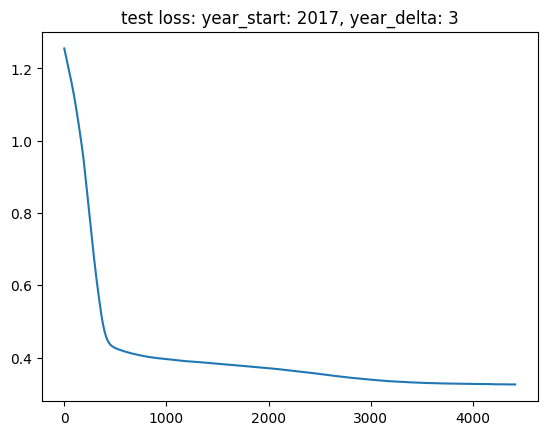

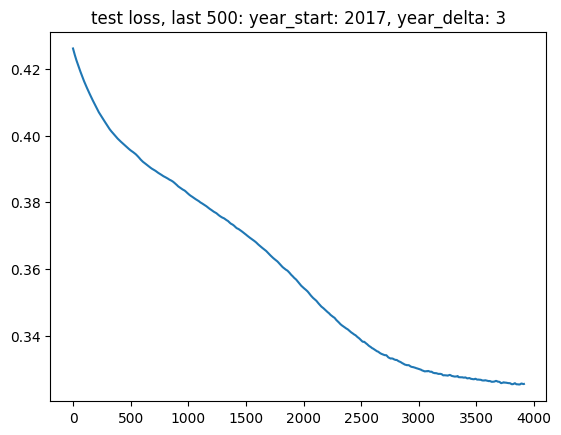

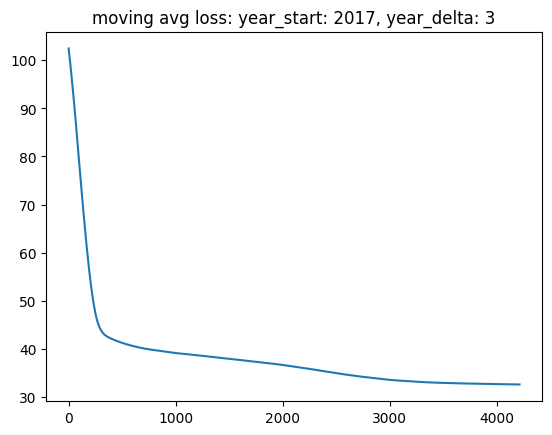

1.4) Computes the AUC for training and test data using calculate_ROC.


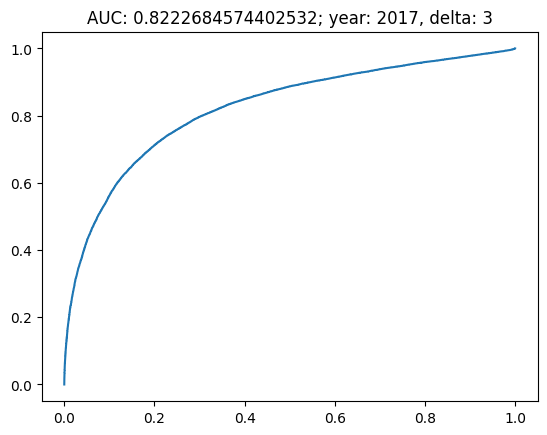

    AUC_train:  0.8222684574402532


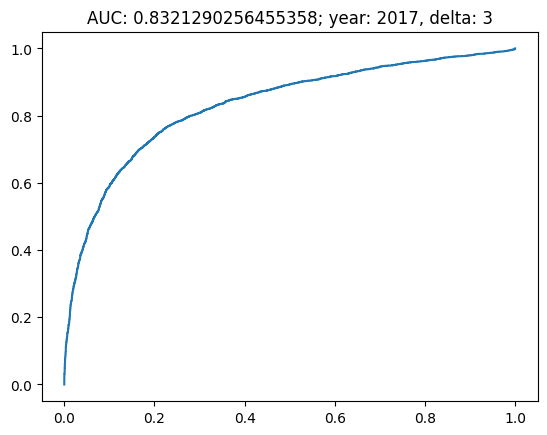

    AUC_test:  0.8321290256455358
2) Makes predictions for 2020 -> 2023 data.
2.1) Computes the 15 properties for the 2020 data.
    Create Graph for  2020
    Create Graph for  2019
    Create Graph for  2018
    compute all properties for evaluation
    Computed all matrix squares, ready to ruuuumbleeee...
    compute_all_properties_of_list progress: ( 1.9361984729766846 sec)  0.0 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.3311495780944824 sec)  0.01 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.3382992744445801 sec)  0.02 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.3467538356781006 sec)  0.03 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.3401153087615967 sec)  0.04 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.3343656063079834 sec)  0.05 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.33020496368408203 sec)  0.06 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.3235921859741211 sec)  0.07 M/ 1

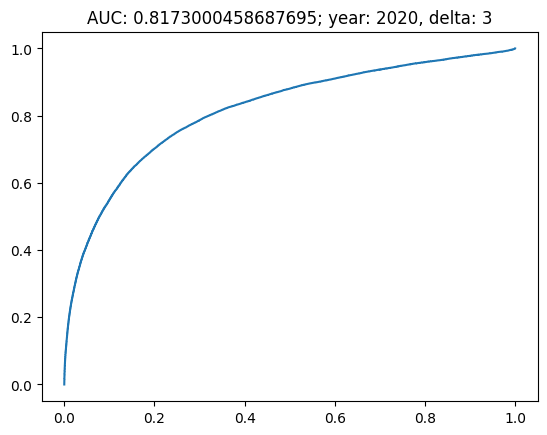

Area Under Curve for Evaluation:  0.8173000458687695 





In [8]:
# Loading the validation data.
#
# full_dynamic_graph_sparse
#           The entire semantic network until 2014 (Validation,CompetitionRun=False) or 2017 (Evaluation&Submission,CompetitionRun=True).
#           numpy array, each entry describes an edge in the semantic network.
#           Each edge is described by three numbers [v1, v2, t], where the edge is formed at time t between vertices v1 and v2
#           t is measured in days since the 1.1.1990
#
# unconnected_vertex_pairs
#           numpy array of vertex pairs v1,v2 with deg(v1)>=vertex_degree_cutoff, deg(v2)>=vertex_degree_cutoff, and no edge exists in the year 2014 (2017 for CompetitionRun=True). 
#           The question that the neural network needs to solve: Will it form at least min_edges edges?
#
# unconnected_vertex_pairs_solution
#           Solution, either yes or no whether edges have been connected
#
# year_start
#           year_start=2014 (2017 for CompetitionRun=True)
#
# years_delta
#           years_delta=3
#
# vertex_degree_cutoff
#           The minimal vertex degree to be used in predictions
#
# min_edges
#           Prediction: From zero to min_edges edges between two vertices

# Testing the model, for validation.

 
all_vertex_degree_cutoff=[1] # vertex degree is 1, means that the vertex is connected to at least one other vertex
all_delta=[3] # time gap, unconnected pairs in y, the corresponding connection in y+delta
all_min_edges=[1] # every two vertices should have at least 1 edge between them
year_start=2023-3

for current_delta in all_delta:
    for curr_vertex_degree_cutoff in all_vertex_degree_cutoff:
        for current_min_edges in all_min_edges:
            cur_year_start=2023-current_delta
            data_source=f"saved_files/SemanticGraph_year_{str(year_start)}_delta_{str(current_delta)}_cutoff_{str(curr_vertex_degree_cutoff)}_minedge_{str(current_min_edges)}.pkl"
    
            if os.path.isfile(data_source):
                with open(data_source, "rb" ) as pkl_file:
                    full_dynamic_graph, unconnected_vertex_pairs, unconnected_vertex_pairs_solution, year_start, year_delta, vertex_degree_cutoff, min_edges = pickle.load(pkl_file)
                ## cur_year_start should be the same as year_start
                
                print(f"unconnected_vertex_pairs: {len(unconnected_vertex_pairs)}")
                print(f"unconnected_vertex_pairs_solution: {len(unconnected_vertex_pairs_solution)}")
                count_ones = np.sum(unconnected_vertex_pairs_solution == 1)
                print("Number of 1s in train_edges_solution:", count_ones)
                print(f"year_start: {year_start}; years_delta: {year_delta}; vertex_degree_cutoff: {vertex_degree_cutoff}; min_edges: {min_edges}")
                #print("Here",year_start,years_delta,year_start+years_delta)
                with open(data_source+"_logs.txt", "a") as myfile:
                    myfile.write('Read'+str(data_source)+'\n') 

                edges_used=1e5
                percent_positive_examples=1
                batch_size=400
                lr_enc=3*10**-5
                full_rnd_seed=[42]
    
                for rnd_seed in full_rnd_seed:
                    hyper_paramters=[edges_used,percent_positive_examples,batch_size,lr_enc,rnd_seed]

                    
                    all_idx = link_prediction_semnet(full_dynamic_graph,
                                                    unconnected_vertex_pairs,
                                                    year_start,#+years_delta,
                                                    year_delta,
                                                    vertex_degree_cutoff,
                                                    min_edges,
                                                    hyper_paramters,
                                                    data_source
                                                    )
                # all_idx = link_prediction_split(full_dynamic_graph,
                    #                                 unconnected_vertex_pairs,
                    #                                 year_start,#+years_delta,
                    #                                 year_delta,
                    #                                 vertex_degree_cutoff,
                    #                                 min_edges,
                    #                                 hyper_paramters,
                    #                                 data_source
                    #                                 )
                    
                    eval_info=f"year: {year_start}, delta: {year_delta}"
                    AUC=calculate_ROC(all_idx, np.array(unconnected_vertex_pairs_solution), eval_info)
                    print('Area Under Curve for Evaluation: ', AUC,'\n\n\n')
    
                    with open(data_source+"_logs.txt", "a") as log_file:
                        log_file.write("---\n")  
                        log_file.write("edges_used="+str(edges_used)+"\n") 
                        log_file.write("percent_positive_examples="+str(percent_positive_examples)+"\n") 
                        log_file.write("batch_size="+str(batch_size)+"\n") 
                        log_file.write("lr_enc="+str(lr_enc)+"\n") 
                        log_file.write("rnd_seed="+str(rnd_seed)+"\n") 
                        log_file.write("AUC="+str(AUC)+"\n\n") 
            else:
                print('File ', data_source, ' does not exist. Proceed to next parameter setting.')

In [17]:
# eval_info = 'year: 2020, delta: 3'
all_idx.shape

(10000000,)

here


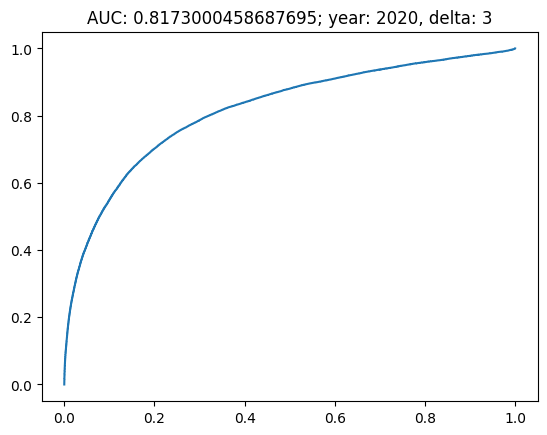

Area Under Curve for Evaluation:  0.8173000458687695 





In [19]:
AUC=calculate_ROC(all_idx, np.array(unconnected_vertex_pairs_solution), eval_info,save=True)
print('Area Under Curve for Evaluation: ', AUC,'\n\n\n')

In [9]:
stop

NameError: name 'stop' is not defined

## check different period?

In [ ]:
if not ('saved_files/full_dynamic_graph_sparse' in locals() or 'saved_files/full_dynamic_graph_sparse' in globals()):
    print('Read full graph')
    with open('saved_files/graph_edges.pkl', "rb" ) as pkl_file:
        full_dynamic_graph_sparse_read = pickle.load(pkl_file)
        
    full_dynamic_graph_sparse=[]
    cc=0
    for edge in full_dynamic_graph_sparse_read:
        if edge[0]!=edge[1]:
            full_dynamic_graph_sparse.append(edge)
        else:
            print(cc,': ',edge) 
            
    full_dynamic_graph_sparse_read=[]        

else:
    print('already stored all_edges')

print('done')

## prepare unconnected pairs for a different checking period 

current_delta=3
curr_vertex_degree_cutoff=1
current_min_edges=1    
year_start=2023-current_delta 

dynamic_graph_sparse, edges_for_checking, edges_for_solution = create_training_data(
    full_graph=np.array(full_dynamic_graph_sparse),
    year_start=year_start,
    years_delta=current_delta,
    min_edges=current_min_edges,
    edges_used=1e7,
    vertex_degree_cutoff=curr_vertex_degree_cutoff,
    NUM_OF_VERTICES=NUM_OF_VERTICES
)

## calculate futures: 
day_origin = date(1990,1,1)
eval_sparse=[]
years=[year_start,year_start-1,year_start-2]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    eval_edges_curr=dynamic_graph_sparse[dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix(
                                            (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                            shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                        )

    eval_sparse.append(adj_mat_sparse_curr)

print('    compute all properties for evaluation')
eval_examples=compute_all_properties_of_list(eval_sparse,edges_for_checking,data_source)
eval_examples=np.array(eval_examples)

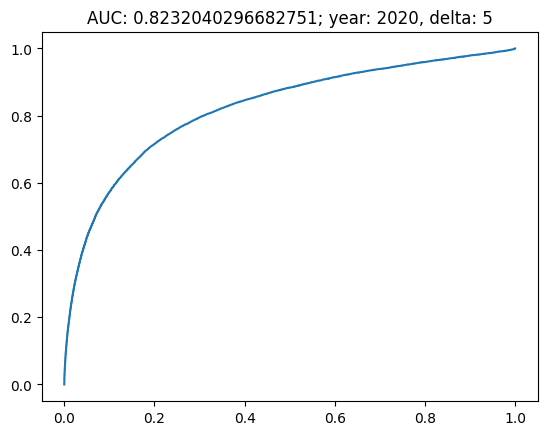

test/evaluate with different time frame, AUC: {AUC}


In [ ]:
 
## load NN 
trained_delta=5 # depend on your train period
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_semnet = MLP().to(device)
model_semnet = torch.load(f"neural_net_full_{2013}_{5}")
model_semnet.eval() 
eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)   
all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())
sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))  
eval_info=f"year: {year_start}, delta: {year_delta}"
AUC=calculate_ROC(sorted_predictions_eval, np.array(edges_for_solution), eval_info)
print(f"test/evaluate with different time frame, AUC: {AUC}")